<a href="https://colab.research.google.com/github/MaCuur/Tesis_PCT/blob/master/Transferencia_de_aprendizaje.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Transferencia de aprendizaje**

Tomando modelos existentes y pre-entrenados para resolver otros problemas

_Eg: diferenciar imágenes jirafas de babuinos_

para facilitarlo se instala la extensión ..Download All Images.. de Chrome
con lo que

**Transferencia de aprendizaje**

Tomando modelos existentes y pre-entrenados para resolver otros problemas

_Eg: diferenciar imágenes jirafas de babuinos_

para facilitarlo se instala la extensión ..Download All Images.. de Chrome
con lo que

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:

  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Sep  4 00:37:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Crear un nuevo conjunto de datos
!unzip babuino/babuino.zip -d babuino
!unzip jirafa/jirafa.zip -d jirafa

Archive:  babuino/babuino.zip
  inflating: babuino/23-02-17-babuino.jpg  
  inflating: babuino/360_F_18253442_WVLdKgWFsUVOZDFz06wrHDHMtK8rKDjh.jpg  
  inflating: babuino/360_F_700119884_t7Wu4jV3zoybyksunvnq5E0TVU4pcDs9.jpg  
  inflating: babuino/1200px-Mandrill_Albert_September_2015_Zoo_Berlin_-2-.jpg  
  inflating: babuino/20120923-k529677.webp  
  inflating: babuino/32642609-baby-baboon-portrait-looking-very-confused-in-close.jpg  
  inflating: babuino/92653688-hamadryas-baboon-in-zoo.jpg  
  inflating: babuino/151025541-angry-baboon-mandrillus-sphinx-shot-in-natural-hab.jpg  
  inflating: babuino/186954086-the-hamadryas-baboon-papio-hamadryas-is-a-species-.jpg  
  inflating: babuino/6663503147_fa4e08d866_z.jpg  
  inflating: babuino/141007115836_baboon_304-jpg.webp  
  inflating: babuino/20210719174540_babuino-laura-camon_foto610x342.jpg  
  inflating: babuino/ape-653705_640.jpg  
  inflating: babuino/a-quien-fastidia-mas-la-vida-una-infancia-dificil-a-un-babui.jpg  
  inflating: ba

In [ ]:
!rm -rf babuino/babuino.zip
!rm -rf jirafa/jirafa.zip

In [ ]:
# crear un set de datos (ya no en memoria )

!mkdir dataset
!cp -r babuino dataset/babuino
!cp -r jirafa  dataset/jirafa

In [ ]:
# Aumento de datos
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# crear el dataset generator
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 10,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 5,
    zoom_range=[0.7, 1.3],
#    horizontal_flip=True,
#    fill_mode='nearest',
    validation_split = 0.2
)

# creando el set de datos de entrenamiento y de pruebas
data_gen_entrenamiento = datagen.flow_from_directory("/content/dataset",
                                               target_size=(224, 224),
                                               batch_size=32, shuffle=True,
                                               subset='training')
                                               #class_mode='categorical',
                                               #subset='training')

data_gen_pruebas = datagen.flow_from_directory("/content/dataset",
                                               target_size=(224, 224),
                                               batch_size=32, shuffle=True,
                                               subset='validation')
                                               #class_mode='categorical',
                                               #subset='validation


Found 555 images belonging to 2 classes.
Found 138 images belonging to 2 classes.


In [ ]:
data_gen_entrenamiento

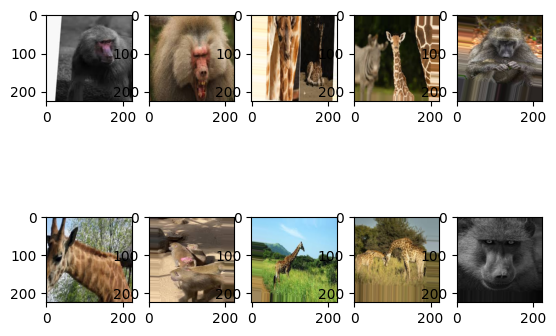

In [ ]:
# mostrando como quedaron las imágenes
import matplotlib.pyplot as plt

#imagenes, etiquetas = next(data_gen_entrenamiento)
for imagenes, etiquetas in data_gen_entrenamiento:
  for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(imagenes[i])
  break
plt.show()

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub # We will not be using tensorflow_hub

#  descarga de modelo pre entrenado por millones de imagenes con mil clases
# google
url ="https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/tf2-preview-feature-vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224, 224, 3))

# Load MobileNetV2 from Keras Applications
mobilenetv2 = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False, # Do not include the ImageNet classifier at the top
    weights='imagenet' # Use weights pre-trained on ImageNet
)

In [ ]:
#conglando las capas
mobilenetv2.trainable = False

In [ ]:
# Define the input layer
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))

# Add the MobileNetV2 base model
x = mobilenetv2(input_layer)

# Add a Global Average Pooling layer to flatten the output of the base model
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add the output dense layer
output_layer = tf.keras.layers.Dense(2, activation='softmax')(x)

# Create the model
modelo = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [ ]:
modelo.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
epocas = 20
entrenamiento = modelo.fit(
    data_gen_entrenamiento,
    epochs=epocas,
    batch_size=32,
    validation_data=data_gen_pruebas
)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5634 - loss: 0.7703 - val_accuracy: 0.9493 - val_loss: 0.1575
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 532ms/step - accuracy: 0.9834 - loss: 0.1173 - val_accuracy: 0.9783 - val_loss: 0.0603
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 573ms/step - accuracy: 0.9705 - loss: 0.0816 - val_accuracy: 0.9928 - val_loss: 0.0395
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 604ms/step - accuracy: 0.9906 - loss: 0.0552 - val_accuracy: 0.9928 - val_loss: 0.0337
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 647ms/step - accuracy: 0.9969 - loss: 0.0351 - val_accuracy: 0.9928 - val_loss: 0.0362
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 538ms/step - accuracy: 0.9863 - loss: 0.0401 - val_accuracy: 0.9928 - val_loss: 0.0312
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 502ms/step - accuracy: 0.9955 - loss: 0.0302 - val_accuracy: 0.9928 - val_loss: 0.0356
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 600ms/step - accuracy: 0.9928 - loss: 0.0282 - val_accuracy: 0.9928 - 

In [ ]:
# probando su funcionalidad

from PIL import Image
import cv2

def categorizar(ruta):
  img = Image.open(ruta)
  img = img.convert("RGB")
  img = np.array(img).astype(float)/255

  img = cv2.resize(img, (224, 224))
  prediccion = modelo.predict(img.reshape(-1, 224, 224, 3))
  return np.argmax(prediccion[0], axis=-1)

In [ ]:
ruta = "test/jirafa_eg.jpg"
prediccion = categorizar(ruta)
print(prediccion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1


In [ ]:
ruta = "test/ape_eg.jpg"
prediccion = categorizar(ruta)
print(prediccion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0
